# Pyspark TensorFlow Inference

## Image classification
Based on: https://www.tensorflow.org/tutorials/keras/save_and_load

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import subprocess
import tensorflow as tf

from tensorflow import keras

print(tf.version.VERSION)

2.8.0


### Load and preprocess dataset

In [2]:
# load dataset as numpy arrays
(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.mnist.load_data()
train_images.shape, test_images.shape

((60000, 28, 28), (10000, 28, 28))

In [3]:
# flatten and normalize
train_images = train_images.reshape(-1, 784) / 255.0
test_images = test_images.reshape(-1, 784) / 255.0

In [4]:
train_images.shape, test_images.shape

((60000, 784), (10000, 784))

### Define a model

In [5]:
# Define a simple sequential model
def create_model():
    model = tf.keras.models.Sequential([
        keras.layers.Dense(512, activation='relu', input_shape=(784,)),
        keras.layers.Dropout(0.2),
        keras.layers.Dense(10)
    ])

    model.compile(optimizer='adam',
                    loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
                    metrics=[tf.metrics.SparseCategoricalAccuracy()])

    return model

# Create a basic model instance
model = create_model()

# Display the model's architecture
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 512)               401920    
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 10)                5130      
                                                                 
Total params: 407,050
Trainable params: 407,050
Non-trainable params: 0
_________________________________________________________________


2022-04-07 14:34:39.763901: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


### Train model

In [6]:
model.fit(train_images, 
          train_labels,  
          epochs=5,
          validation_data=(test_images, test_labels))

Epoch 1/5
1875/1875 [==============================] - 8s 4ms/step - loss: 0.2207 - sparse_categorical_accuracy: 0.9333 - val_loss: 0.1030 - val_sparse_categorical_accuracy: 0.9672
Epoch 2/5
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0987 - sparse_categorical_accuracy: 0.9695 - val_loss: 0.0855 - val_sparse_categorical_accuracy: 0.9736
Epoch 3/5
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0692 - sparse_categorical_accuracy: 0.9784 - val_loss: 0.0692 - val_sparse_categorical_accuracy: 0.9797
Epoch 4/5
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0530 - sparse_categorical_accuracy: 0.9828 - val_loss: 0.0803 - val_sparse_categorical_accuracy: 0.9767
Epoch 5/5
1875/1875 [==============================] - 8s 4ms/step - loss: 0.0437 - sparse_categorical_accuracy: 0.9859 - val_loss: 0.0709 - val_sparse_categorical_accuracy: 0.9784


In [7]:
test_img = test_images[:1]
model.predict(test_img)

array([[ -7.358786 ,  -7.1993732,  -3.222292 ,  -1.5091399, -12.832173 ,
         -8.094815 , -19.598206 ,  12.633436 ,  -6.5144963,  -2.5135467]],
      dtype=float32)

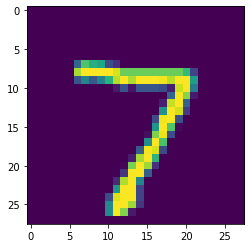

In [8]:
plt.figure()
plt.imshow(test_img.reshape(28,28))
plt.show()

### Save Model

In [9]:
subprocess.call("rm -rf mnist_model".split())

0

In [10]:
model.save('mnist_model')

INFO:tensorflow:Assets written to: mnist_model/assets


2022-04-07 14:35:18.049458: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


### Inspect saved model

In [11]:
subprocess.call("tree mnist_model".split())

mnist_model
├── assets
├── keras_metadata.pb
├── saved_model.pb
└── variables
    ├── variables.data-00000-of-00001
    └── variables.index

2 directories, 4 files


0

In [12]:
subprocess.call("saved_model_cli show --dir mnist_model --tag_set serve --signature_def serving_default".split())

The given SavedModel SignatureDef contains the following input(s):
  inputs['dense_input'] tensor_info:
      dtype: DT_FLOAT
      shape: (-1, 784)
      name: serving_default_dense_input:0
The given SavedModel SignatureDef contains the following output(s):
  outputs['dense_1'] tensor_info:
      dtype: DT_FLOAT
      shape: (-1, 10)
      name: StatefulPartitionedCall:0
Method name is: tensorflow/serving/predict


0

### Load model

In [13]:
new_model = tf.keras.models.load_model('mnist_model')
new_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 512)               401920    
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 10)                5130      
                                                                 
Total params: 407,050
Trainable params: 407,050
Non-trainable params: 0
_________________________________________________________________


In [14]:
new_model.inputs

[<KerasTensor: shape=(None, 784) dtype=float32 (created by layer 'dense_input')>]

### Predict

In [15]:
new_model.predict(test_images[:1])

array([[ -7.358786 ,  -7.1993732,  -3.222292 ,  -1.5091399, -12.832173 ,
         -8.094815 , -19.598206 ,  12.633436 ,  -6.5144963,  -2.5135467]],
      dtype=float32)

## PySpark

In [16]:
import pandas as pd

# from pyspark.sql.functions import col, pandas_udf, PandasUDFType
# from pyspark.sql.types import *

### Convert numpy array to Spark DataFrame (via Pandas DataFrame)

In [17]:
# numpy array to pandas DataFrame
test_pdf = pd.DataFrame(test_images)
test_pdf.shape

(10000, 784)

In [18]:
%%time
# 784 columns of float
df = spark.createDataFrame(test_pdf)

CPU times: user 50.9 s, sys: 0 ns, total: 50.9 s
Wall time: 53.1 s


In [19]:
%%time
# 1 column of array<float>
test_pdf['data'] = test_pdf.values.tolist()
pdf = test_pdf[['data']]
pdf.shape

CPU times: user 218 ms, sys: 0 ns, total: 218 ms
Wall time: 215 ms


(10000, 1)

In [20]:
%%time
df = spark.createDataFrame(pdf).repartition(10)

CPU times: user 311 ms, sys: 0 ns, total: 311 ms
Wall time: 413 ms


### Save the test dataset as parquet files

In [21]:
df.write.mode("overwrite").parquet("mnist_test")

22/04/07 14:36:15 WARN TaskSetManager: Stage 0 contains a task of very large size (4315 KiB). The maximum recommended task size is 1000 KiB.


### Check arrow memory configuration

In [22]:
spark.conf.set("spark.sql.execution.arrow.maxRecordsPerBatch", "128")
# This line will fail if the vectorized reader runs out of memory
assert len(df.head()) > 0, "`df` should not be empty" 

22/04/07 14:36:19 WARN TaskSetManager: Stage 3 contains a task of very large size (4315 KiB). The maximum recommended task size is 1000 KiB.


## Inference using Spark ML Model
Note: you can restart the kernel and run from this point to simulate running in a different node or environment.

In [23]:
import sparkext

In [24]:
df = spark.read.parquet("mnist_test")

In [25]:
model = sparkext.tensorflow.Model("mnist_model") \
            .setInputCol("data") \
            .setOutputCol("preds")

In [26]:
predictions = model.transform(df)

Loading model on driver from mnist_model
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 512)               401920    
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 10)                5130      
                                                                 
Total params: 407,050
Trainable params: 407,050
Non-trainable params: 0
_________________________________________________________________
ModelSummary(num_params=407050, inputs=[TensorSummary(shape=[None, 784], dtype=tf.float32, name='dense_input')], outputs=[TensorSummary(shape=[None, 10], dtype=tf.float32, name='dense_1/BiasAdd:0')]) -> array<float>
INFO:tensorflow:Assets written to: ram://8be8f697-cbed-45

In [27]:
predictions.write.mode("overwrite").parquet("mnist_predictions")

### Check predictions

In [28]:
import matplotlib.pyplot as plt
import numpy as np

In [29]:
%%time
preds = predictions.collect()

CPU times: user 791 ms, sys: 0 ns, total: 791 ms
Wall time: 2.17 s


In [30]:
preds[0].preds

[-14.681986808776855,
 -8.035789489746094,
 -8.756430625915527,
 -0.6912011504173279,
 -14.260246276855469,
 15.426255226135254,
 -6.493452072143555,
 -16.083724975585938,
 -6.774261474609375,
 -1.4227932691574097]

In [31]:
img = preds[0].data
img = np.array(img).reshape(28,28)

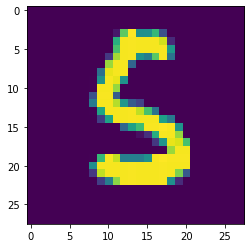

In [32]:
plt.figure()
plt.imshow(img)
plt.show()

## Inference using Spark DL UDF
Note: you can restart the kernel and run from this point to simulate running in a different node or environment.

In [33]:
from pyspark.sql.functions import col

In [34]:
df = spark.read.parquet("mnist_test")

In [35]:
df.schema

StructType(List(StructField(data,ArrayType(DoubleType,true),true)))

In [36]:
from sparkext.tensorflow import model_udf

In [37]:
mnist = model_udf("mnist_model", batch_size=500)

Loading model on driver from mnist_model
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 512)               401920    
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 10)                5130      
                                                                 
Total params: 407,050
Trainable params: 407,050
Non-trainable params: 0
_________________________________________________________________
ModelSummary(num_params=407050, inputs=[TensorSummary(shape=[None, 784], dtype=tf.float32, name='dense_input')], outputs=[TensorSummary(shape=[None, 10], dtype=tf.float32, name='dense_1/BiasAdd:0')]) -> array<float>


In [38]:
%%time
preds = df.withColumn("preds", mnist(col("data"))).collect()

INFO:tensorflow:Assets written to: ram://e7565c0c-6b63-4f56-91b2-fe8e508434d0/assets


CPU times: user 782 ms, sys: 90.2 ms, total: 872 ms
Wall time: 2.13 s


### Check predictions

In [39]:
preds[0].preds

[-14.681986808776855,
 -8.035789489746094,
 -8.756430625915527,
 -0.6912011504173279,
 -14.260246276855469,
 15.426255226135254,
 -6.493452072143555,
 -16.083724975585938,
 -6.774261474609375,
 -1.4227932691574097]

In [40]:
import matplotlib.pyplot as plt
import numpy as np

In [41]:
img = preds[0].data
img = np.array(img).reshape(28,28)

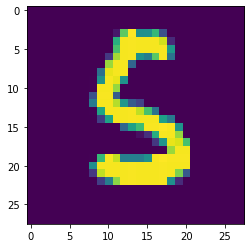

In [42]:
plt.figure()
plt.imshow(img)
plt.show()